In [1]:
import numpy as np
import tensorflow as tf
from data_loader import data_load
from IPython.display import clear_output
from model.model import fcn_decoder,vgg16_encoder
import datetime
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

IMG_WIDTH = 128
IMG_HEIGHT = 128

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
        print(e)
        
        
encoder = vgg16_encoder((IMG_HEIGHT, IMG_WIDTH,3))
decoder_src = fcn_decoder((IMG_HEIGHT, IMG_WIDTH,3), encoder)
decoder_dst = fcn_decoder((IMG_HEIGHT, IMG_WIDTH,3), encoder)


In [2]:
src_dataset, dst_dataset = data_load()

In [3]:
src_optimizer = tf.keras.optimizers.Adam(1e-4)
dst_optimizer = tf.keras.optimizers.Adam(1e-4)

src_loss = tf.keras.metrics.Mean(name='train_loss')
dst_loss = tf.keras.metrics.Mean(name='train_loss')

In [4]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
src_log_dir = 'logs/fcn_log/gradient_tape/' + current_time + '/src'
dst_log_dir = 'logs/fcn_log/gradient_tape/' + current_time + '/dst'

src_summary_writer = tf.summary.create_file_writer(src_log_dir)
dst_summary_writer = tf.summary.create_file_writer(dst_log_dir)

In [5]:
def show_predictions(flag):
    
    img_idx = [0, 1000, 2000, 3000]
    src = []
    dst = []
    
    for i in img_idx:
        src += [(img, land) for img, land in src_dataset.skip(i).take(1)] 
        dst += [(img, land) for img, land in dst_dataset.skip(i).take(1)] 
    
    plt.figure(figsize=(7,7))
    if flag =="src":
        for i in range(4):
            plt.subplot(4,4, 4*i +1)
            plt.imshow(src[i][1])
            plt.axis('off')
            plt.title("src landmark")
            
            plt.subplot(4,4, 4*i +2)
            plt.imshow(decoder_src(src[i][1][tf.newaxis,...])[0])  
            plt.title("pred_src")
            plt.axis('off')
            
            plt.subplot(4,4, 4*i +3)
            plt.imshow(decoder_dst(src[i][1][tf.newaxis,...])[0])  
            plt.title("pred_dst")
            plt.axis('off')
            
            plt.subplot(4,4, 4*i +4)
            plt.imshow(src[i][0])   
            plt.title("src image")
            plt.axis('off')
    else:
        for i in range(4):
            plt.subplot(4,4, 4*i +1)
            plt.imshow(dst[i][1])
            plt.axis('off')
            plt.title("dst landmark")
            
            plt.subplot(4,4, 4*i +2)
            plt.imshow(decoder_dst(dst[i][1][tf.newaxis,...])[0])  
            plt.axis('off')
            plt.title("pred_dst")

            plt.subplot(4,4, 4*i +3)
            plt.imshow(decoder_src(dst[i][1][tf.newaxis,...])[0])  
            plt.title("pred_src")
            plt.axis('off')
            
            plt.subplot(4,4, 4*i +4)
            plt.imshow(dst[i][0])   
            plt.title("dst image")
            plt.axis('off') 

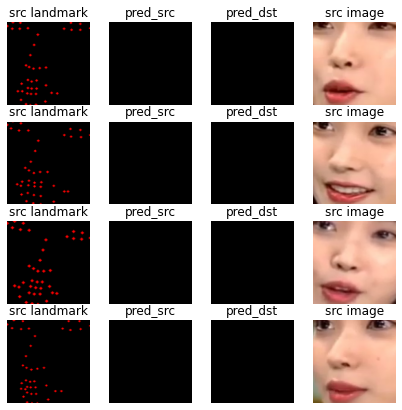

In [6]:
show_predictions("src")

In [7]:
@tf.function
def src_train_step(src_img, src_land):
    
    with tf.GradientTape() as tape:
        pred_src = decoder_src(src_land)
        
        src_batch_loss =  tf.keras.losses.MSE(pred_src, src_img)

    gradients_of_src_model = tape.gradient(src_batch_loss, decoder_src.trainable_variables)

    src_optimizer.apply_gradients(zip(gradients_of_src_model, decoder_src.trainable_variables))

    src_loss(src_batch_loss)

@tf.function
def dst_train_step(dst_img, dst_land):
    
    with tf.GradientTape() as tape:
        pred_dst = decoder_dst(dst_land)
        
        dst_batch_loss =  tf.keras.losses.MSE(pred_dst, dst_img)

    gradients_of_dst_model = tape.gradient(dst_batch_loss, decoder_dst.trainable_variables)

    dst_optimizer.apply_gradients(zip(gradients_of_dst_model, decoder_dst.trainable_variables))

    dst_loss(dst_batch_loss)

In [12]:
def train(src_dataset, dst_dataset, epochs, batch_size):
    
    src_best_loss =10
    dst_best_loss =10
    
    
    for epoch in range(750, epochs):
        
        if epoch >=100:
            src_optimizer = tf.keras.optimizers.Adam(1e-5)
            dst_optimizer = tf.keras.optimizers.Adam(1e-5)

        if epoch >=1000:
            src_optimizer = tf.keras.optimizers.Adam(1e-6)
            dst_optimizer = tf.keras.optimizers.Adam(1e-5)

        
        start = time.time()

        src_loss.reset_states()
        dst_loss.reset_states()
      
        
        batch_time = time.time()
        batch_idx = 0
        
        for image_batch, land_batch in src_dataset.batch(batch_size):
                        
            '''if tf.random.uniform(()) > 0.5:
                image_batch = tf.image.flip_left_right(image_batch)
                label_batch = tf.image.flip_left_right(land_batch)'''

            
            src_train_step(image_batch, land_batch)
            
        clear_output(wait=True)
        #show_predictions("src")      
                
                
        print('epoch {}, loss {} , time {}'.format(epoch+1, src_loss.result(), time.time()- batch_time))

        
        for image_batch, land_batch in dst_dataset.batch(batch_size):
                        
            '''if tf.random.uniform(()) > 0.5:
                
                image_batch = tf.image.flip_left_right(image_batch)
                label_batch = tf.image.flip_left_right(land_batch)'''

            
            dst_train_step(image_batch, land_batch)
            
    
        clear_output(wait=True)
        #show_predictions("dst")      
        
        
        print('epoch {}, loss {} , time {}'.format(epoch+1, dst_loss.result(), time.time()- batch_time))
        
        if src_best_loss > src_loss.result().numpy():
            src_path = "model_h5/fcn/src2.h5" 
            src_best_loss =src_loss.result().numpy()
            decoder_src.save(src_path)

        if dst_best_loss > dst_loss.result().numpy():
            dst_path = "model_h5/fcn/dst2.h5" 
            dst_best_loss =dst_loss.result().numpy()
            decoder_dst.save(dst_path)

            
        with src_summary_writer.as_default():
                tf.summary.scalar('loss', src_loss.result(), step=epoch+1)
                
        with dst_summary_writer.as_default():
                tf.summary.scalar('loss', dst_loss.result(), step=epoch+1)

In [13]:
train(src_dataset, dst_dataset, 3000, 100)

epoch 1003, loss 0.00023581247660331428 , time 33.371431827545166


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


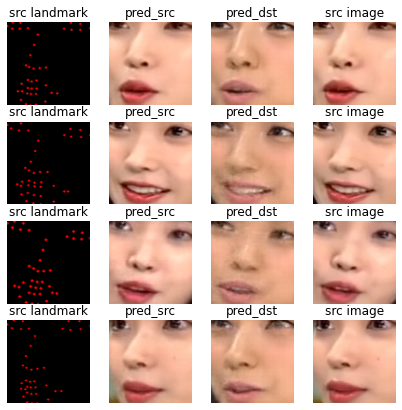

In [14]:
show_predictions("src")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


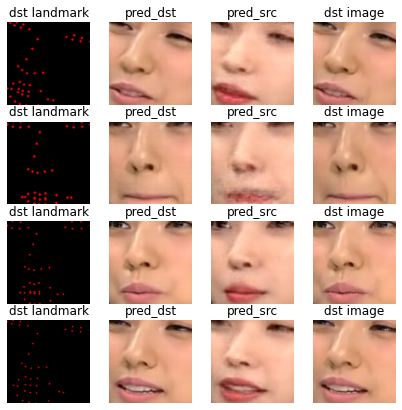

In [15]:
show_predictions("dst")